In [3]:
import os
import sqlite3
from typing import TypedDict, Annotated

import requests
from dotenv import load_dotenv
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from loguru import logger
import gradio as gr


In [4]:

load_dotenv(override=True)


True

In [5]:

logger.info("Start LangGraph with SQL lite in-memory")
# Tool - Web

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")
tool_search = Tool(
    name="search",
    func=serper.run,
    description="Useful for when you need more information from an online search")
# Tool 2 - push
PUSHOVER_USER = os.getenv("PUSHOVER_USER")
PUSHOVER_TOKEN = os.getenv("PUSHOVER_TOKEN")
PUSHOVER_URL = os.getenv("PUSHOVER_URL")


def push(txt: str):
    """ Send a push notification to the user """
    logger.info(txt)
    requests.post(PUSHOVER_URL, data={"token": PUSHOVER_USER, "user": PUSHOVER_TOKEN, "message": txt})


tool_push = Tool(
    name="send_push_notification",
    description="Useful when you want to send push notification.",
    func=push
)

tools = [tool_search, tool_push]

## SQL-Lite as memory Saver
logger.info(f"SqliteSaver added ....")
db_path = "langgraph.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory_saver = SqliteSaver(conn)

## STEP1- State Builder
logger.info("STEP-1- State Builder")


class State(TypedDict):
    messages: Annotated[list, add_messages]


##STEP2:
logger.info("STEP-2: Graph Builder")

graph_builder = StateGraph(State)

##STEP3: Setup lllm and bind tools
logger.info("STEP-3: Setup lllm and bind tools")

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    logger.info(state["messages"])
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

##STEP4: Add Edges
logger.info("STEP-4:  Add Edges")

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

## STEP5:
logger.info("STEP-5: Compile Graph with SQL Memory Saver check point")
graph = graph_builder.compile(checkpointer=sql_memory_saver)

2025-10-28 08:48:57.506 | INFO     | __main__:<module>:1 - Start LangGraph with SQL lite in-memory
2025-10-28 08:48:59.314 | INFO     | __main__:<module>:31 - SqliteSaver added ....
2025-10-28 08:48:59.322 | INFO     | __main__:<module>:37 - STEP-1- State Builder
2025-10-28 08:48:59.324 | INFO     | __main__:<module>:45 - STEP-2: Graph Builder
2025-10-28 08:48:59.326 | INFO     | __main__:<module>:50 - STEP-3: Setup lllm and bind tools
2025-10-28 08:49:01.080 | INFO     | __main__:<module>:65 - STEP-4:  Add Edges
2025-10-28 08:49:01.083 | INFO     | __main__:<module>:73 - STEP-5: Compile Graph with SQL Memory Saver check point


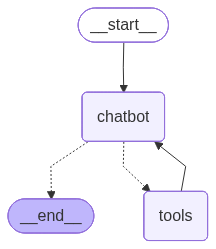

In [6]:
graph

In [7]:
confg = {"configurable": {"thread_id": "3"}}


def chat(user_input, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=confg)
    return result["messages"][-1].content

In [8]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
